age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64
age               float64
bp                float64
sg                  int64
al                  int64
su                  int64
rbc                 int32
pc                  int32
pcc                 int32
ba                  int32
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wc                float64
rc                float64
htn                

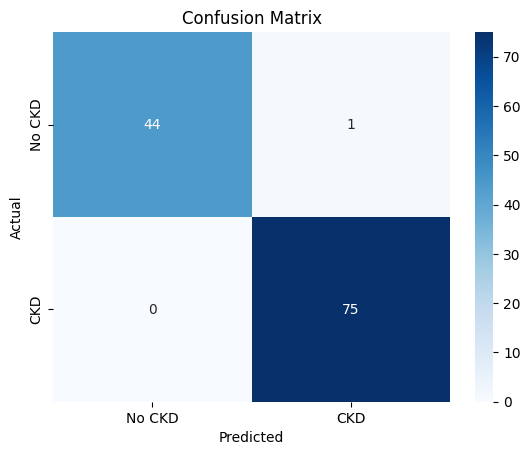

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

data = pd.read_csv('kidney_disease.csv')
# Misclassified data
data[['pcv', 'wc', 'rc']] = data[['pcv', 'wc', 'rc']].apply(pd.to_numeric, errors='coerce')
data_cleaned = data
numeric_columns = ['age', 'bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
non_numeric_columns = ['sg', 'al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane'] 
label_encoder = LabelEncoder()
data.replace('ckd\t', 'ckd', inplace = True)
data.replace(' yes', 'yes', inplace = True)
data.replace('\tno', 'no', inplace = True)
data.replace('\tyes', 'yes', inplace = True)
for column in non_numeric_columns:
    data[column] = data[column].fillna(data[column].mode()[0])
    # data[column] = data[column].astype('category')
    data[column] = label_encoder.fit_transform(data[column])

data = data.drop(['id'], axis = 1)
print(data.isnull().sum())
print(data.dtypes)
print(data)

X = data.drop(columns=['classification'])  # Features
y = data['classification'] 
y = y.map({'ckd': 1, 'notckd': 0})
# y_encoded = OrdinalEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False)

# Hyperparams to be tuned
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Step size
    'max_depth': [3, 5, 7],  # Depth of each tree
    'subsample': [0.8, 1],  # Subsample ratio of training instances
    'colsample_bytree': [0.8, 1]  # Feature sampling
}

# Grid search with cross-validation
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
# Print the best parameters

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Evaluate Model
print("Best Parameters:", grid_search.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CKD', 'CKD'], yticklabels=['No CKD', 'CKD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [53]:
binary_map = {'yes': 1, 'no': 0}
appet_map = {'good': 0, 'poor': 1}
rbc_pc_map = {'normal': 1, 'abnormal': 0}
pcc_ba_map = {'present': 0, 'notpresent': 1}
sg_map = {'0.005':0, '1.01':1, '1.015':2, '1.02':3, '1.025':4}
al_su_map = {'0':0, '1':1,'2':2,'3':3,'4':4}

def predict_ckd():
    print("\nEnter patient details for CKD prediction:")

    input_data = []

    # Get user input for numeric features
    for feature in numeric_columns:
        value = float(input(f"Enter {feature}: "))
        input_data.append(value)

    # Get user input for categorical features
    for feature in non_numeric_columns:
        if feature in binary_map:  
            options = "yes/no"
            value = input(f"Enter {feature} ({options}): ").strip().lower()
            input_data.append(binary_map.get(value, 0))  # Default to 'no' if invalid
        elif feature == "appet":
            options = "good/poor"
            value = input(f"Enter {feature} ({options}): ").strip().lower()
            input_data.append(appet_map.get(value, 0))  # Default to 'poor' if invalid
        elif feature in ["rbc", "pc"]:
            options = "normal/abnormal"
            value = input(f"Enter {feature} ({options}): ").strip().lower()
            input_data.append(rbc_pc_map.get(value, 0))  # Default to 'abnormal' if invalid
        elif feature in ["pcc", "ba"]:
            options = "present/notpresent"
            value = input(f"Enter {feature} ({options}): ").strip().lower()
            input_data.append(pcc_ba_map.get(value, 0))  # Default to 'notpresent' if invalid
        elif feature == "sg":
            options = "1.02, 1.01, 1.005, 1.025, 1.015"
            value = input(f"Enter {feature} ({options}): ").strip().lower()
            input_data.append(sg_map.get(value,0))
        elif feature in ["al", "su"]:
            options = "0, 1, 2, 3, 4"
            value = input(f"Enter {feature} ({options}): ").strip().lower()
            input_data.append(al_su_map.get(value,0))
        else:
            value = input(f"Enter {feature}: ")
            value_encoded = label_encoder.transform([value])[0]  # Label Encoding
            input_data.append(value_encoded)

    # Convert input data to NumPy array and reshape for model prediction
    input_array = np.array(input_data).reshape(1, -1)

    # Make prediction
    prediction = best_xgb.predict(input_array)[0]

    # Output result
    if prediction == 1:
        print("\n🔴 Prediction: The patient is likely to have Chronic Kidney Disease (CKD).")
    else:
        print("\n🟢 Prediction: The patient is unlikely to have Chronic Kidney Disease (CKD).")

# Run the function
predict_ckd()


Enter patient details for CKD prediction:

🔴 Prediction: The patient is likely to have Chronic Kidney Disease (CKD).
